In [159]:
import numpy as np
from SPARQLWrapper import SPARQLWrapper, JSON

def get_exact_wikidata_topics(wikipedia_title):
    endpoint_url = "https://query.wikidata.org/sparql"
    query = f"""
    SELECT ?subclassLabel WHERE {{
      ?item rdfs:label "{wikipedia_title}"@en .
      ?item wdt:P279 ?subclass .  # P279 is the property for 'subclass of'
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en" }}
    }}
    """

    sparql = SPARQLWrapper(endpoint_url)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    topics = []
    for result in results["results"]["bindings"]:
        subclass = result["subclassLabel"]["value"]
        topics.append(subclass)

    return topics

wikipedia_title = "matrix multiplication"
topics = get_exact_wikidata_topics(wikipedia_title)

print(topics)

['multiplication', 'matrix operation']


In [37]:
import DataPrep

keywords, keyword_appearances = DataPrep.prep_keywords(min_appearances=50)

/Users/bene/PycharmProjects/Topic Clustering/.venv/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [45]:
sample = keywords.sample(n=10)
for keyword in sample:
    parents = get_exact_wikidata_topics(keyword.lower())
    print(keyword, "subclass of: " , parents)

Grammar subclass of:  ['linguistics', 'convention']
Algebraic geometry subclass of:  []
Climatology subclass of:  ['meteorology', 'oceanography', 'physical geography', 'atmospheric physics']
Enterprise resource planning subclass of:  ['information technology', 'business software']
Financial market subclass of:  ['market', 'academic discipline']
Process engineering subclass of:  ['engineering']
Electrochemistry subclass of:  ['physical chemistry']
Electric generator subclass of:  ['electric machine', 'electric power source']
Mathematics education subclass of:  ['education']
Human musculoskeletal system subclass of:  ['human organ system', 'musculoskeletal system', 'particular anatomical entity']


In [130]:
import json
import pandas as pd

# Load JSON data

def load_wiki_hierachy(include_list_items = True):
    with open('database/wikipedia_overview_categories_revised.json', 'r') as file:
        data = json.load(file)
    
    row_list = []
    # Function to flatten the JSON structure
    def flatten_json(y, parents=[]):
        if isinstance(y, dict):
            for k, v in y.items():
                flatten_json(v, parents + [k])
        elif isinstance(y, list):
            for i, item in enumerate(y):
                flatten_json(item, parents)
                if not include_list_items:
                    break
        else:
            new_row = {}
            parents = parents + [y]
            for i, parent in enumerate(parents):
                new_row[f"level {i}"] = parent
            row_list.append(new_row)
    
    
    flatten_json(data["Wikipedia_Contents"])
    wiki_df = pd.DataFrame.from_dict(row_list).replace({'_': ' '}, regex=True)
    
    wiki_df["leaf nodes"] = wiki_df['level 3'].fillna(wiki_df['level 2'])
    wiki_df = wiki_df.drop_duplicates(subset="leaf nodes", keep="first")
    return wiki_df

wiki_df = load_wiki_hierachy(include_list_items = False)
wiki_df

,level 0,level 1,level 2,level 3,leaf nodes
0,Culture and the arts,Culture and Humanities,Celebrities,NaN,Celebrities
1,Culture and the arts,Art and The arts,Art galleries,NaN,Art galleries
2,Culture and the arts,Literature,Poetry,NaN,Poetry
3,Culture and the arts,Performing arts,Comedy (Humour),NaN,Comedy (Humour)
4,Culture and the arts,Visual arts,Animation,NaN,Animation
...,...,...,...,...,...
91,Society and social sciences,Economy and Business,Finance,NaN,Finance
92,Society and social sciences,Education,Academia,NaN,Academia
93,Society and social sciences,Government and Politics,Politics by country,NaN,Politics by country
94,Society and social sciences,Law,Criminal justice,NaN,Criminal justice


In [131]:
import plotly.express as px

px.treemap(wiki_df, path=["level 0", "level 1", "level 2", "level 3"], template="simple_white", title="Hierarchy Explorer")

In [144]:
import Clustering
import DataPrep

keywords = wiki_df["level 1"].tolist()
keyword_embeddings = DataPrep.embed_keywords(keywords)

/Users/bene/PycharmProjects/Topic Clustering/Clustering.py:121: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



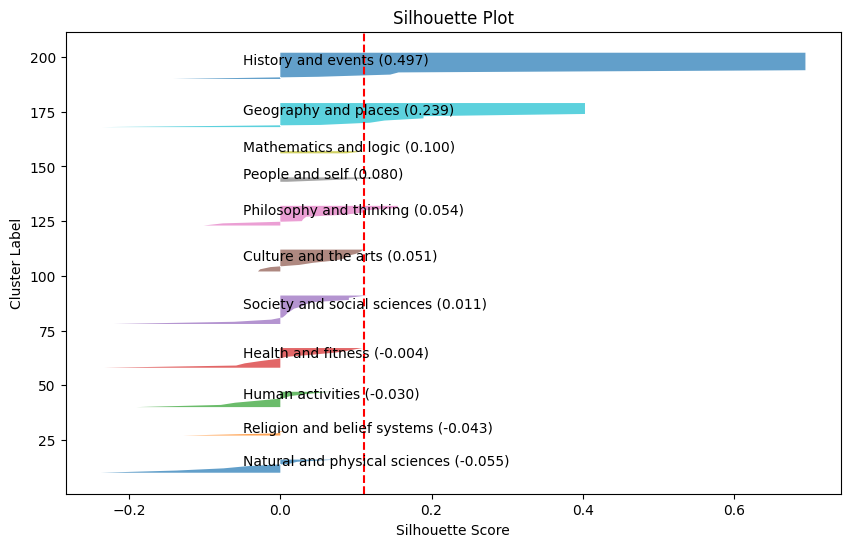

In [145]:
## check the silhoutte score of the wikipedia structure

from sklearn.metrics import silhouette_score, silhouette_samples
wiki_df["score"] = silhouette_samples(keyword_embeddings, wiki_df["level 0"])
Clustering.plot_silhouette(wiki_df, cluster_label_col='level 0', silhouette_score_col='score', outlier_percentile=1, plot_height=6)

In [146]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

Z = linkage(keyword_embeddings, method='ward')

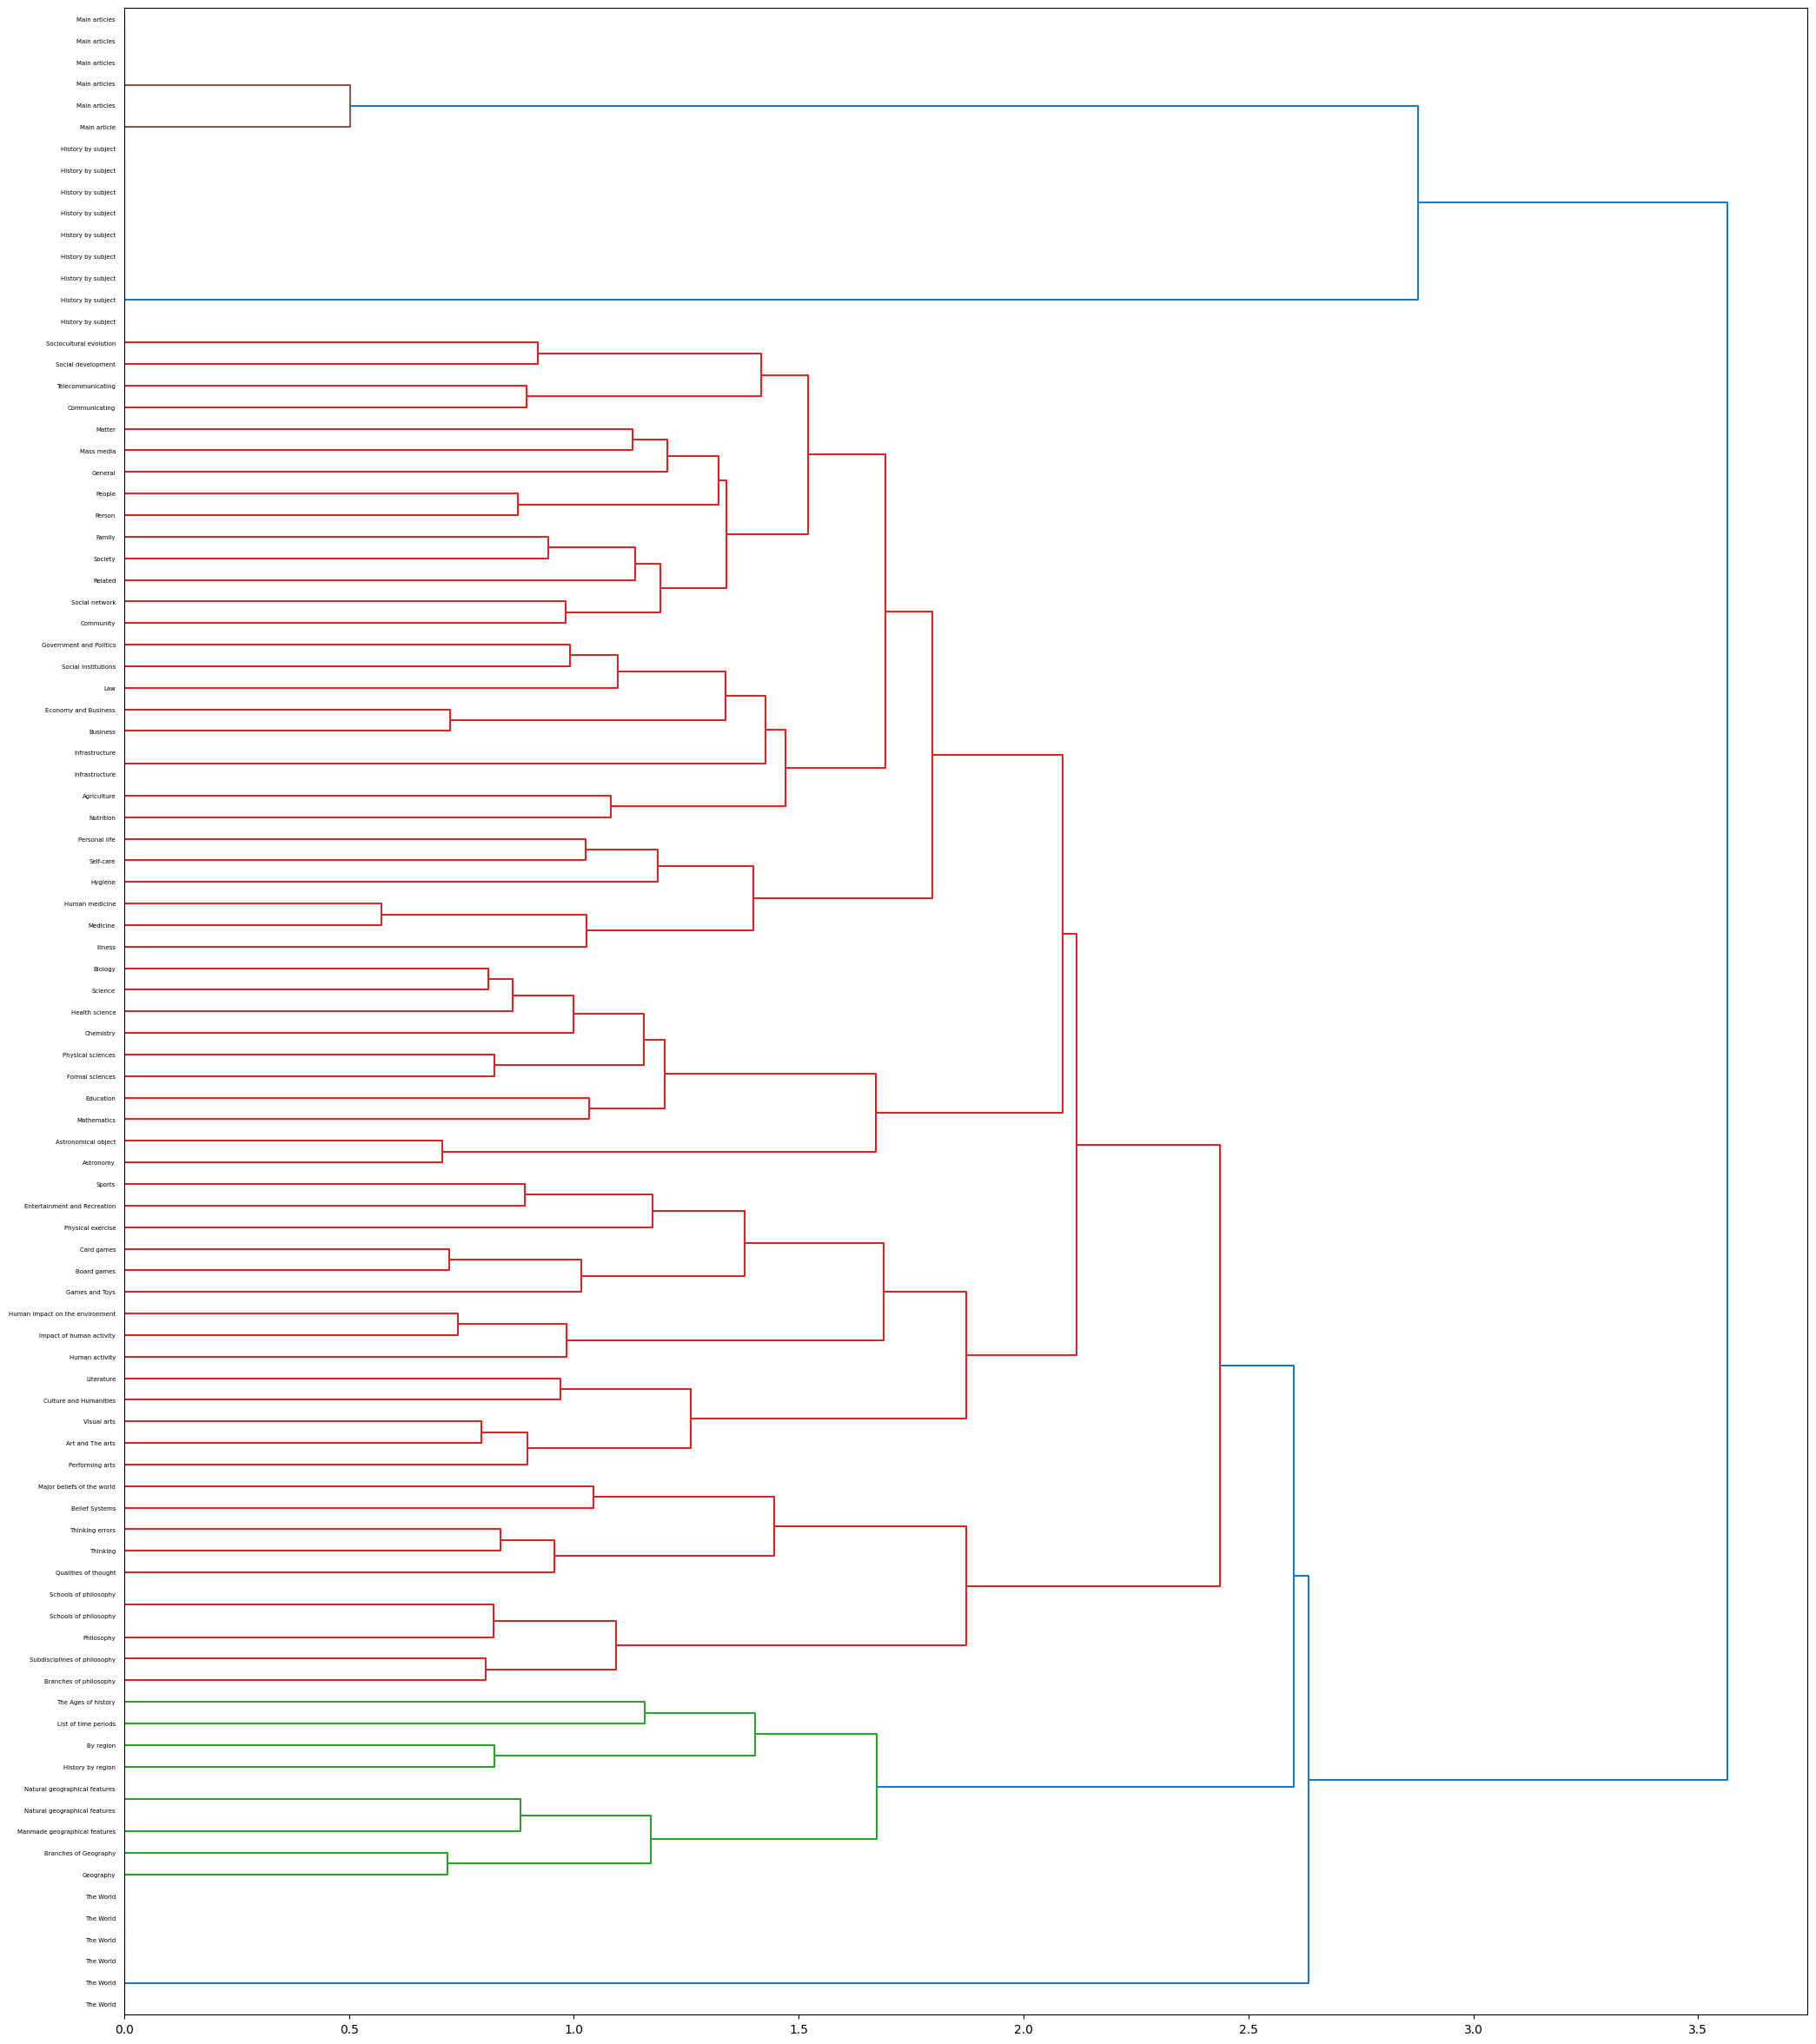

In [155]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(25, 30))
dn = dendrogram(Z, labels=keywords, orientation='right')

In [150]:
import numpy as np

mock_appearances = np.full(shape=len(keywords), fill_value=10)
df = Clustering.keyword_hierachy(keywords, keyword_embeddings, mock_appearances, cutting_distances=[1., 2.5, 3], Z=Z, dist_weight=1.0)

keyword count: 93
cluster count: 45
cluster count: 5
cluster count: 2


In [151]:
df["true level 3"] = wiki_df["level 0"]

/Users/bene/PycharmProjects/Topic Clustering/Clustering.py:121: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



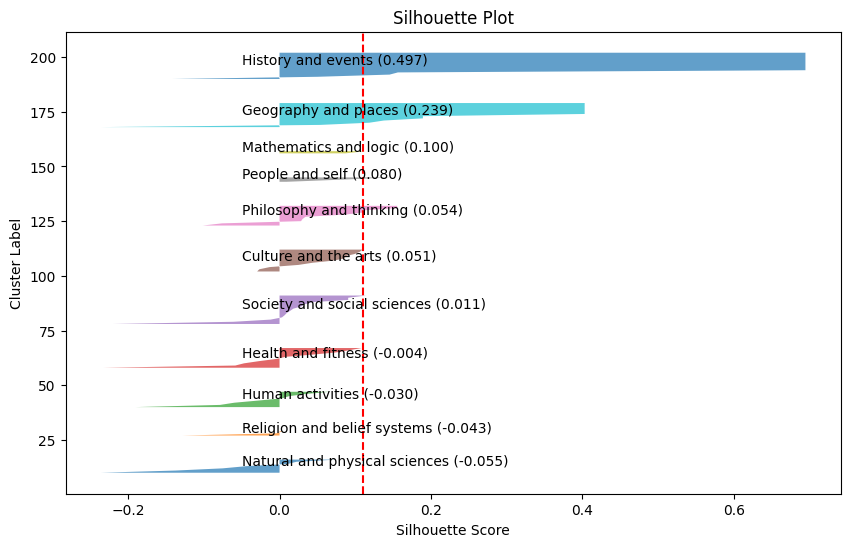

/Users/bene/PycharmProjects/Topic Clustering/Clustering.py:121: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



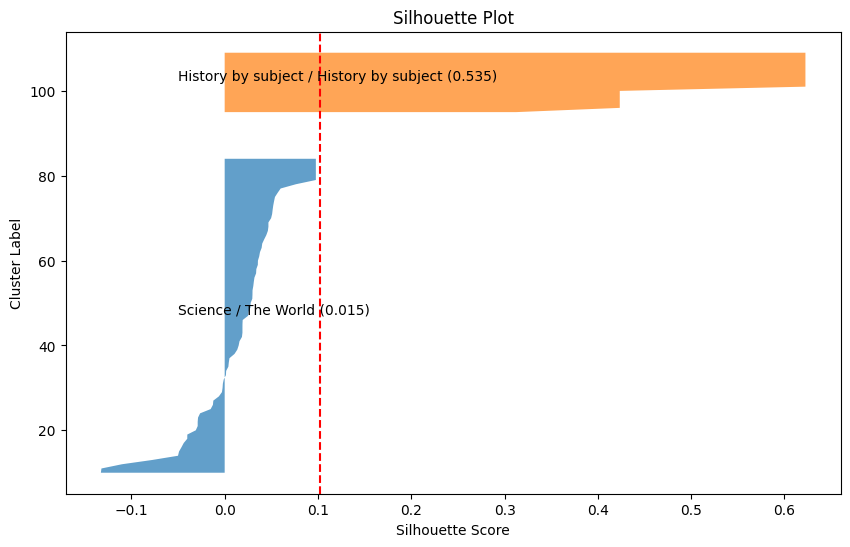

In [161]:
Clustering.plot_silhouette(wiki_df, cluster_label_col='level 0', silhouette_score_col='score', outlier_percentile=1, plot_height=6)
Clustering.plot_silhouette(df, cluster_label_col='level 3', silhouette_score_col='level 3 score', outlier_percentile=1, plot_height=6)

In [160]:
from sklearn.metrics import adjusted_rand_score, jaccard_score, rand_score

# Calculate ARI
df = df.dropna()
true_labels = df["true level 3"]
predicted_labels = df["level 3"] 
ari_score = rand_score(true_labels, predicted_labels)
jaccard_score = jaccard_score(true_labels, predicted_labels, average='macro')

ari_score, jaccard_score

(np.float64(0.349812734082397), np.float64(0.0))